## Using a Deep Neural Network to Predict the All-NBA Teams for the 2021-22 NBA Season 

### Import standard libraries


In [1]:
from datetime import datetime
sartTime = datetime.now()

In [2]:
import pandas as pd
#import pandas_profiling
#from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.style.use('fivethirtyeight')
%matplotlib inline

### Read All-NBA (1988-2019) data from Wikipedia

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/All-NBA_Team', header=None)[7]

In [4]:
df.head()

Season              First team                             Second team  \
    Season                 Players               Teams             Players   
0  1988–89        Karl Malone* (2)           Utah Jazz        Tom Chambers   
1  1988–89    Charles Barkley* (4)  Philadelphia 76ers       Chris Mullin*   
2  1988–89  Akeem Olajuwon* (4)[d]     Houston Rockets  Patrick Ewing* (2)   
3  1988–89     Michael Jordan* (4)       Chicago Bulls  John Stockton* (2)   
4  1988–89      Magic Johnson* (8)  Los Angeles Lakers       Kevin Johnson   

                                      Third team                       
                   Teams                 Players                Teams  
0           Phoenix Suns  Dominique Wilkins* (4)        Atlanta Hawks  
1  Golden State Warriors      Terry Cummings (2)      Milwaukee Bucks  
2        New York Knicks      Robert Parish* (2)       Boston Celtics  
3              Utah Jazz              Dale Ellis  Seattle SuperSonics  
4           Phoenix Suns              Mark Price  Cleveland Cavaliers

### Cleanup All-NBA Data

In [5]:
df.columns = df.columns.droplevel() # Drop first levl of header

df.drop('Teams', axis = 1, inplace= True) # Drop the Team columns

In [6]:
df.columns = ['season_name', 'first_team', 'second_team', 'third_team' ]

In [7]:
#Strip () and [] from names

df['first_team'] = df['first_team'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)).apply(lambda x: re.sub(r'\[[^)]*\]', '', x)).apply(lambda x: x.replace('^', ''))
df['second_team'] = df['second_team'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)).apply(lambda x: re.sub(r'\[[^)]*\]', '', x)).apply(lambda x: x.replace('^', ''))
df['third_team'] = df['third_team'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)).apply(lambda x: re.sub(r'\[[^)]*\]', '', x)).apply(lambda x: x.replace('^', ''))

In [8]:
df.head()

,season_name,first_team,second_team,third_team
0,1988–89,Karl Malone*,Tom Chambers,Dominique Wilkins*
1,1988–89,Charles Barkley*,Chris Mullin*,Terry Cummings
2,1988–89,Akeem Olajuwon*,Patrick Ewing*,Robert Parish*
3,1988–89,Michael Jordan*,John Stockton*,Dale Ellis
4,1988–89,Magic Johnson*,Kevin Johnson,Mark Price


### Get Team Records

In [9]:
records_df = pd.read_csv('Team_Summaries.csv', encoding='utf8')
records_df.rename(columns={'abbreviation':'tm'}, inplace = True)

In [10]:
records_df.head()

,season,lg,team,tm,playoffs,age,w,l,pw,pl,...,tov_percent,orb_percent,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,arena,attend,attend_g
0,2022,NBA,Atlanta Hawks,ATL,False,26.1,43.0,39.0,45.0,37.0,...,10.8,23.0,0.205,0.543,11.5,76.9,0.177,State Farm Arena,672742.0,16408.0
1,2022,NBA,Boston Celtics,BOS,False,26.1,51.0,31.0,59.0,23.0,...,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,727928.0,17754.0
2,2022,NBA,Brooklyn Nets,BRK,False,29.1,44.0,38.0,43.0,39.0,...,12.5,23.9,0.198,0.521,11.7,75.1,0.201,Barclays Center,711539.0,17355.0
3,2022,NBA,Chicago Bulls,CHI,False,26.3,46.0,36.0,40.0,42.0,...,11.8,20.4,0.201,0.541,11.9,78.3,0.199,United Center,856148.0,20882.0
4,2022,NBA,Charlotte Hornets,CHO,False,25.5,43.0,39.0,42.0,40.0,...,11.6,23.3,0.173,0.544,13.1,74.8,0.187,Spectrum Center,700755.0,17092.0


### Data Engineering to prepare for Machine Learning

In [11]:
df['1st'] = '1st'
df['2nd'] = '2nd'
df['3rd'] = '3rd' 

In [12]:
df1st = pd.DataFrame()
df2nd = pd.DataFrame()
df3rd = pd.DataFrame()
df1st[['season_name', 'player', 'all_nba_team']] = df[['season_name', 'first_team', '1st']]
df2nd[['season_name', 'player', 'all_nba_team']] = df[['season_name', 'second_team', '2nd']]
df3rd[['season_name', 'player', 'all_nba_team']] = df[['season_name', 'third_team', '3rd']]

In [13]:
all_nba_df = df1st.append([df2nd, df3rd], ignore_index=True)

In [14]:
all_nba_df.head()

,season_name,player,all_nba_team
0,1988–89,Karl Malone*,1st
1,1988–89,Charles Barkley*,1st
2,1988–89,Akeem Olajuwon*,1st
3,1988–89,Michael Jordan*,1st
4,1988–89,Magic Johnson*,1st


### Further cleaning up ALL-NBA data 

In [15]:
def remove_trail_space(player):
    if player[-1] == ' ':
        player = player[0:-1]
        return player
    else:
        return player
    
all_nba_df['player'] = all_nba_df['player'].apply(remove_trail_space)

#Clean up players with dfferent names

all_nba_df['season_name'] = all_nba_df['season_name'].apply(lambda x: x.replace('–', '-'))
all_nba_df['player'] = all_nba_df['player'].apply(lambda x: x.replace('*', ''))

all_nba_df['player'].loc[all_nba_df['player'] == 'Amare Stoudemire'] = 'Amar\'e Stoudemire' 

all_nba_df['player'].loc[all_nba_df['player'] == 'Akeem Olajuwon'] = 'Hakeem Olajuwon'

all_nba_df['player'].loc[all_nba_df['player'] == 'Penny Hardaway'] = 'Anfernee Hardaway'

all_nba_df['player'].loc[all_nba_df['player'] == 'Ron Artest'] = 'Metta World Peace'

all_nba_df.head()

,season_name,player,all_nba_team
0,1988-89,Karl Malone,1st
1,1988-89,Charles Barkley,1st
2,1988-89,Hakeem Olajuwon,1st
3,1988-89,Michael Jordan,1st
4,1988-89,Magic Johnson,1st


## Read historical NBA stats (1989 - 2020)

In [16]:
adv_df = pd.read_csv('adv_stats.csv', encoding = 'utf8')
per_game_df = pd.read_csv('per_game_stats.csv', encoding = 'utf8')

In [17]:
# Merge databases on common columns

share_cols = list(set(list(adv_df.columns)).intersection(list(per_game_df.columns)))

nba_df = adv_df.merge(per_game_df, on = share_cols)
nba_df = nba_df[nba_df.season >= 1988]

### Merge Stats and Award Winners Databases 

In [18]:
# First modify the season column to match the format of the Award Winners Databse (eg. 1998-99)

nba_df['season_name'] = (nba_df.season -1).astype(str) +'-' + (nba_df.season).astype(str).str[-2:]
nba_df = pd.merge(nba_df, all_nba_df, how='left', on=['player', 'season_name'])

In [19]:
nba_df.head()

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,season_name,all_nba_team
0,29648,2022,4219,Aaron Gordon,NaN,PF,26.0,8,NBA,DEN,...,4.2,5.9,2.5,0.6,0.6,1.8,2.0,15.0,2021-22,NaN
1,29649,2022,4899,Aaron Henry,NaN,SF,22.0,1,NBA,PHI,...,0.2,0.2,0.0,0.0,0.3,0.3,0.3,0.3,2021-22,NaN
2,29650,2022,4582,Aaron Holiday,NaN,PG,25.0,4,NBA,TOT,...,1.6,1.9,2.4,0.7,0.1,1.1,1.5,6.3,2021-22,NaN
3,29651,2022,4582,Aaron Holiday,NaN,PG,25.0,4,NBA,WAS,...,1.4,1.6,1.9,0.6,0.2,1.0,1.5,6.1,2021-22,NaN
4,29652,2022,4582,Aaron Holiday,NaN,PG,25.0,4,NBA,PHO,...,1.8,2.5,3.4,0.8,0.0,1.3,1.5,6.8,2021-22,NaN


### Replace non-winners (NAN) with NO

In [20]:
nba_df.all_nba_team.fillna('no', inplace=True)

### Check for award winners that changed teams (TOT)

In [21]:
tot_list = nba_df[(nba_df['tm'] == 'TOT') &(nba_df['all_nba_team'] != 'no') ].index.tolist()

nba_df.loc[tot_list]

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,season_name,all_nba_team
8406,21680,2009,3048,Chauncey Billups,NaN,PG,32.0,12,NBA,TOT,...,2.6,3.0,6.4,1.2,0.2,2.2,2.0,17.7,2008-09,3rd
12864,17365,2001,2648,Dikembe Mutombo,NaN,C,34.0,10,NBA,TOT,...,9.4,13.5,1.0,0.4,2.7,1.9,2.7,10.0,2000-01,2nd
16000,14174,1995,2110,Clyde Drexler,NaN,SG,32.0,12,NBA,TOT,...,4.3,6.3,4.8,1.8,0.6,2.4,2.7,21.8,1994-95,3rd
16497,13738,1994,2058,Dominique Wilkins,NaN,SF,34.0,12,NBA,TOT,...,4.0,6.5,2.3,1.2,0.4,2.3,1.7,26.0,1993-94,3rd


Only four players have won All-NBA during a season they changed teams. These are asigned under tm = TOT. Since we want to consider team records and player season totals, we will asign the TOT data points to the team the palyer played most of the season with. Additionally, we will remove the additional teams that appear alongside TOT since these are partial season totals. 

To visualize this, consider the example below for Chauncy Billups, who won 3rd team on 2008-09 and was traded from Denver to Detroit halfway through the season.

In [22]:
nba_df[(nba_df.player =='Chauncey Billups')&(nba_df.season == 2009)]

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,season_name,all_nba_team
8406,21680,2009,3048,Chauncey Billups,NaN,PG,32.0,12,NBA,TOT,...,2.6,3.0,6.4,1.2,0.2,2.2,2.0,17.7,2008-09,3rd
8407,21681,2009,3048,Chauncey Billups,NaN,PG,32.0,12,NBA,DET,...,4.5,5.0,7.5,1.5,0.5,2.0,1.5,12.5,2008-09,3rd
8408,21682,2009,3048,Chauncey Billups,NaN,PG,32.0,12,NBA,DEN,...,2.6,3.0,6.4,1.2,0.2,2.2,2.1,17.9,2008-09,3rd


In [23]:
# Create temporary DataFrame to store non-TOT stats

nba_df['sp_id'] = nba_df.season_name + nba_df.player_id.astype(str)
notot_df = nba_df[nba_df.tm != 'TOT']
notot_df = notot_df.groupby(by =['sp_id', 'player', 'tm'])['g'].max().reset_index()
notot_df = notot_df.sort_values(by = ['sp_id','g'], ascending = False)
notot_df.rename(columns={'tm': 'mx_tm'}, inplace= True)
notot_df = notot_df.drop_duplicates(subset = ['sp_id']).drop('g', axis = 1)

In [24]:
nba_df  = nba_df.merge(notot_df, on =['sp_id', 'player'])
nba_df.sort_values(by = ['season','g'], ascending = False)
nba_df = nba_df.drop_duplicates(subset = ['sp_id'])

### Merge Stats and Team Records Databases 

In [25]:
# Create winning percentage column
records_df['win%'] = records_df.w/(records_df.w+records_df.l)

nba_df = pd.merge(nba_df, records_df[['season', 'tm', 'win%']],
                  left_on = ['season', 'mx_tm'], right_on = ['season', 'tm'])


# Data Visualization 

Text(0, 0.5, 'Total Players')

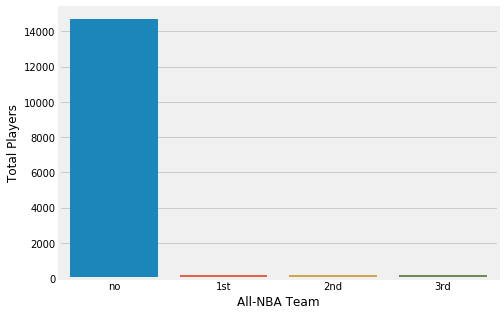

In [26]:
plt.figure(figsize=(7, 5))
sns.countplot(x='all_nba_team', data=nba_df[nba_df.season_name != '2021-22'])
plt.xlabel('All-NBA Team')
plt.ylabel('Total Players')

Data is heavily skewed towards non-winners. This make sense as there are only 15 All-NBA recipients per year 

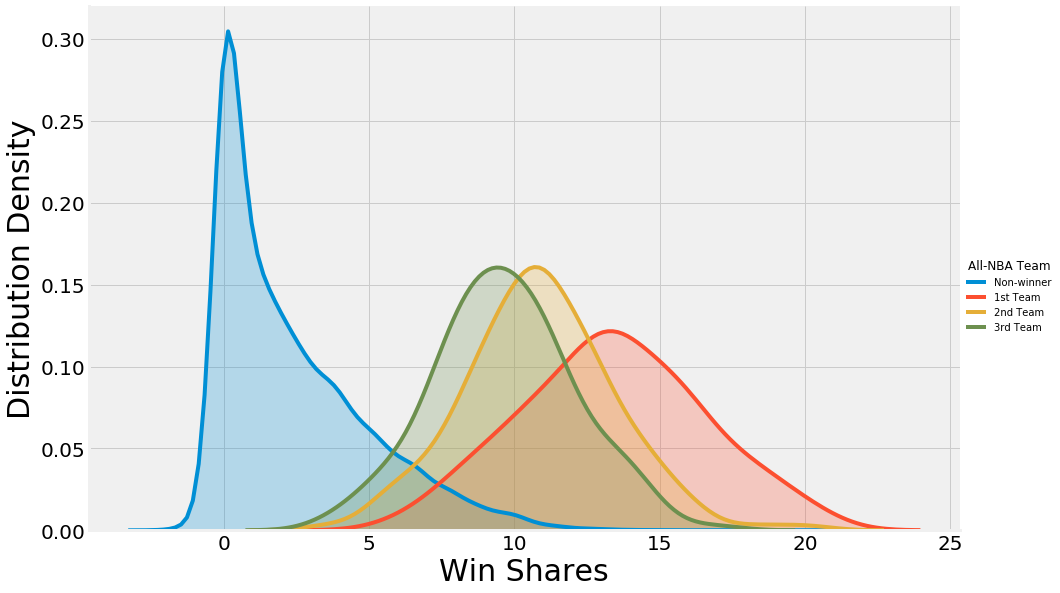

In [57]:
g = sns.FacetGrid(nba_df[nba_df.season_name != '2021-22'],
                   hue="all_nba_team", height=8, aspect=1.6)
g = g.map(sns.kdeplot, "ws", shade=True).add_legend()

plt.xlabel('Win Shares', fontsize=30)
plt.ylabel('Distribution Density', fontsize=30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#g.savefig('WS_allNBA.pdf', bbox_inches='tight')

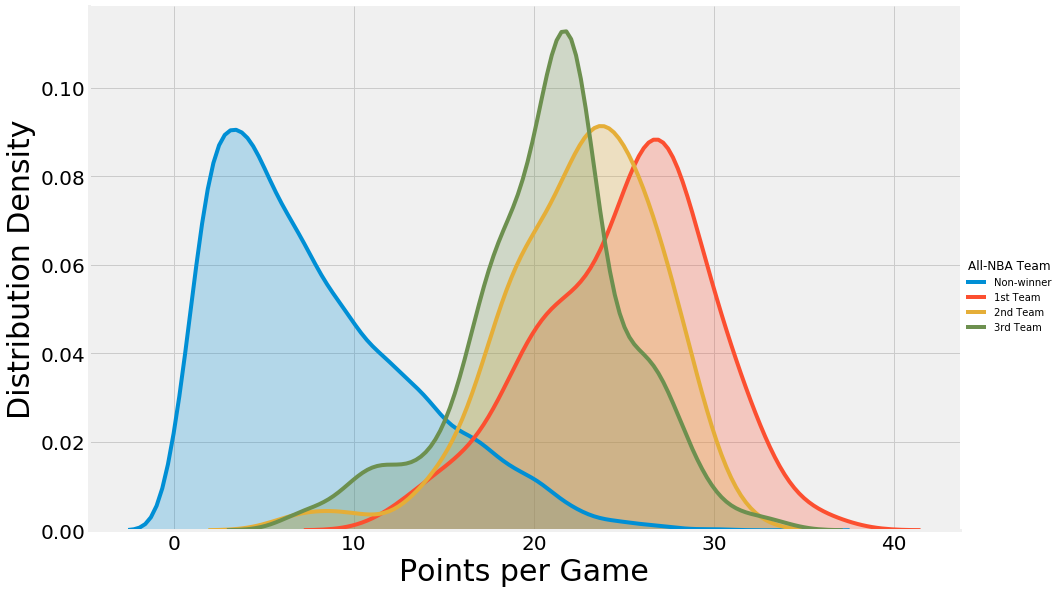

In [28]:
g = sns.FacetGrid(nba_df[nba_df.season_name != '2019-20'],
                  hue = "all_nba_team", height = 8, aspect = 1.6)
g = g.map(sns.kdeplot, "pts_per_game", shade = True).add_legend()
plt.xlabel('Points per Game', fontsize = 30)
plt.ylabel('Distribution Density', fontsize = 30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#g.savefig('WS_allNBA.pdf', bbox_inches = 'tight')

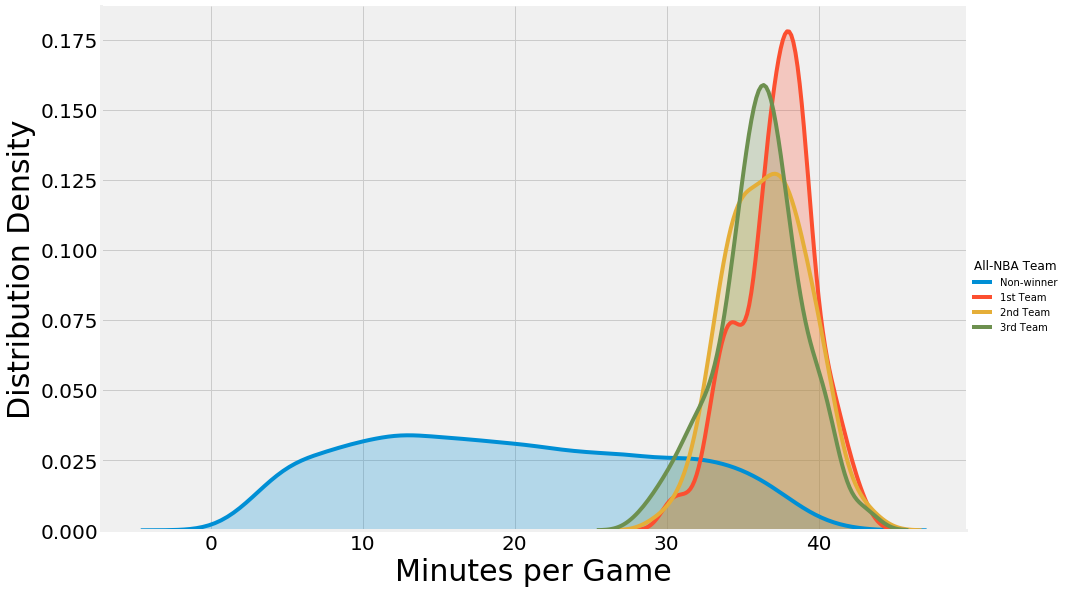

In [29]:
g = sns.FacetGrid(nba_df[nba_df.season_name != '2021-22'],
                  hue="all_nba_team", height=8, aspect=1.6)
g = g.map(sns.kdeplot, "mp_per_game", shade=True).add_legend()

plt.xlabel('Minutes per Game', fontsize = 30)
plt.ylabel('Distribution Density', fontsize = 30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#g.savefig('MPG_allNBA.pdf', bbox_inches='tight')

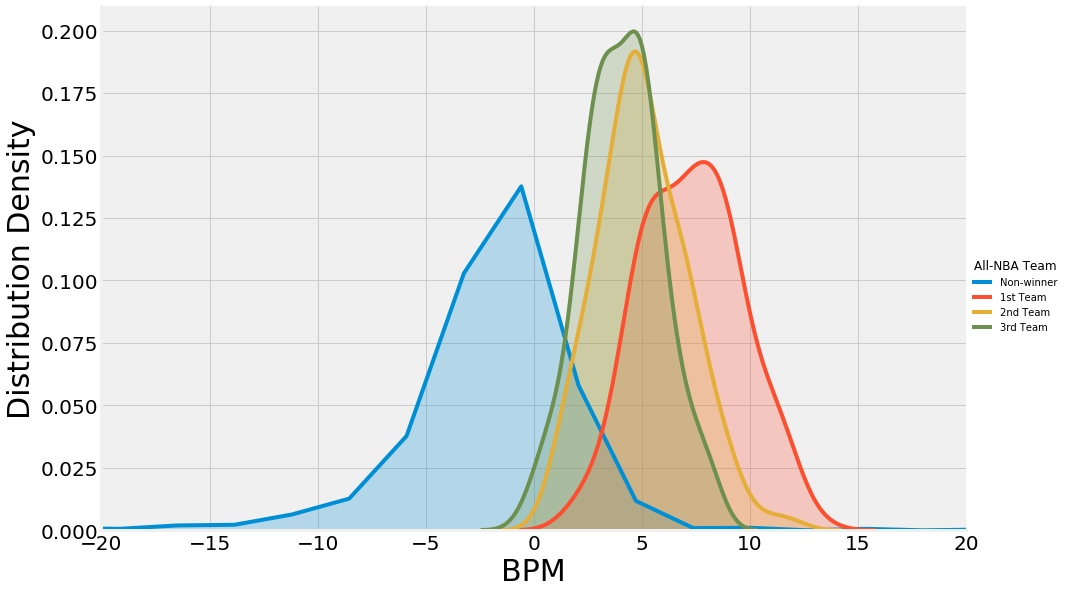

In [30]:
g = sns.FacetGrid(nba_df[nba_df.season_name != '2021-22'],
                   hue="all_nba_team", height=8, aspect=1.6)
g = g.map(sns.kdeplot, "bpm", shade=True).add_legend()

plt.xlabel('BPM', fontsize=30)
plt.ylabel('Distribution Density', fontsize=30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-20,20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#g.savefig('Salary_allNBA.pdf', bbox_inches='tight')

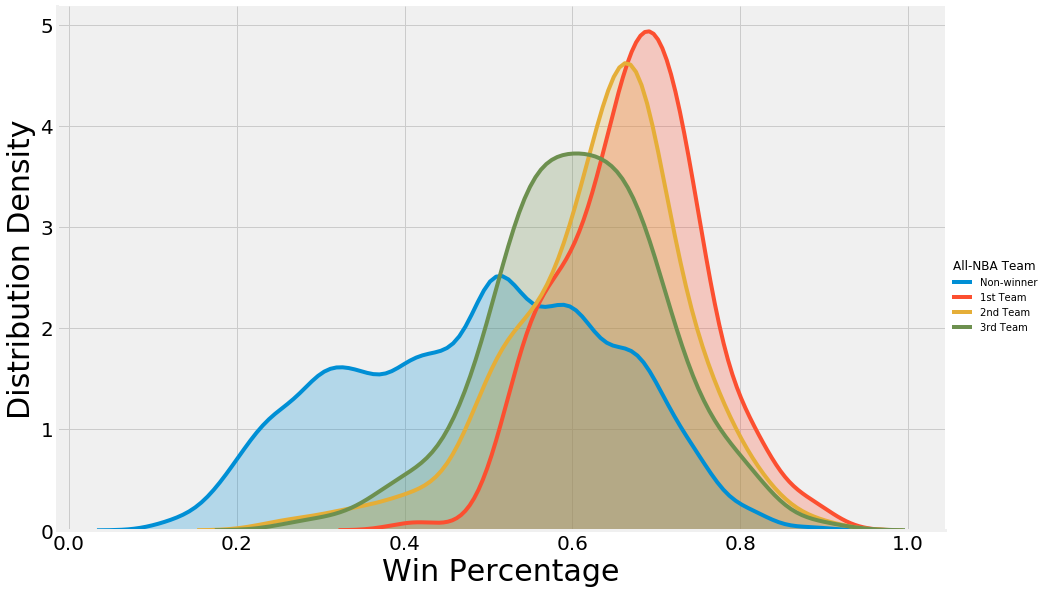

In [31]:
g = sns.FacetGrid(nba_df[nba_df.season_name != '2021-22']
                  , hue = "all_nba_team", height = 8, aspect = 1.6)
g = g.map(sns.kdeplot, "win%", shade = True).add_legend()
plt.xlabel('Win Percentage', fontsize = 30)
plt.ylabel('Distribution Density', fontsize = 30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

## Combine images in one figure

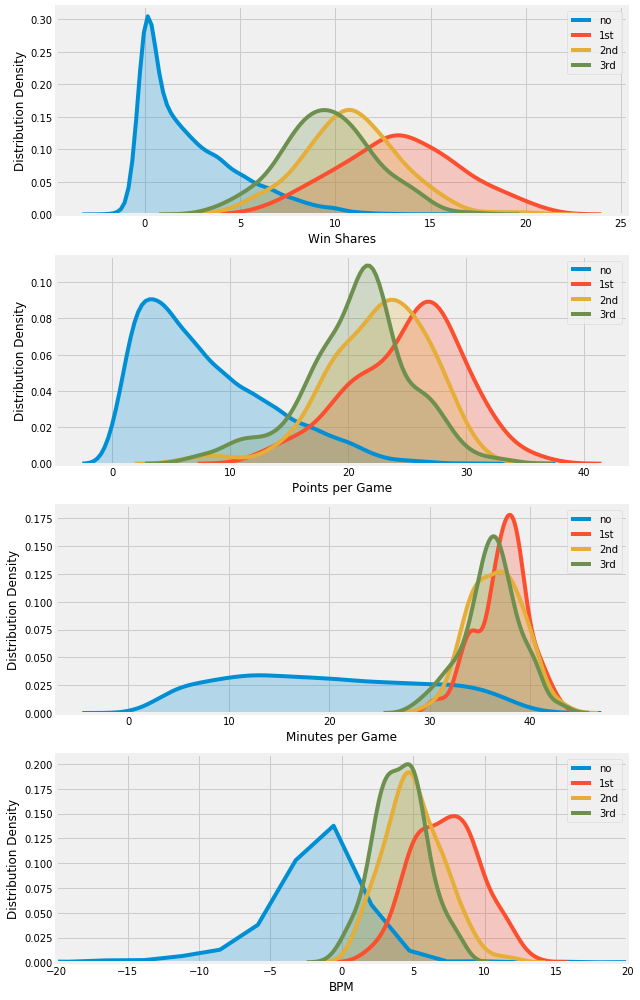

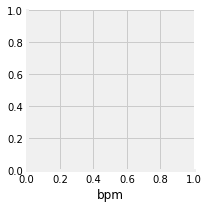

In [32]:
f, axes = plt.subplots(nrows=4, figsize =(9,14))

p = sns.FacetGrid(nba_df[nba_df.season_name != '2021-22'], hue="all_nba_team")

axes[0].set(xlabel='Win Shares', ylabel='Distribution Density')
p.map(sns.kdeplot, "ws", shade=True, ax = axes[0])


axes[1].set(xlabel='Points per Game', ylabel='Distribution Density')
p.map(sns.kdeplot, "pts_per_game", shade=True, ax=axes[1])

axes[2].set(xlabel='Minutes per Game', ylabel='Distribution Density')
p.map(sns.kdeplot, "mp_per_game", shade=True, ax=axes[2])

axes[3].set(xlabel='BPM', ylabel='Distribution Density', xlim=(-.2,1))
p.map(sns.kdeplot, "bpm", shade=True, ax=axes[3])
axes[3].set_xlim(-20,20)

f.tight_layout()

f.savefig('Comb_allNBA.png', dpi = 300)


### Select Machine Learning Features

In [58]:
# Select features
features = ['g', 'gs', 'x2p_per_game', 'x2pa_per_game', 'x3p_per_game', 'x3pa_per_game', 
            'ft_per_game','fta_per_game', 'ts_percent', 'per', 'win%', 'tov_percent',
            'ows', 'dws', 'obpm', 'dbpm', 'vorp', 'usg_percent',
            'orb_per_game', 'drb_per_game', 'ast_per_game', 'stl_per_game', 
            'blk_per_game','tov_per_game', 'pf_per_game', 'pts_per_game', 'mp_per_game']

print('There are', len(features), 'features.')

There are 27 features.


In [59]:
nba_df.columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm_x', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar',
       'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent',
       'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows',
       'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'gs',
       'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent',
       'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game',
       'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game',
       'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game',
       'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game',
       'tov_per_game', 'pf_per_game', 'pts_per_game', 'season_name',
       'all_nba_team', 'sp_id', 'mx_tm', 'tm_y', 'win%'],
      dtype='object')

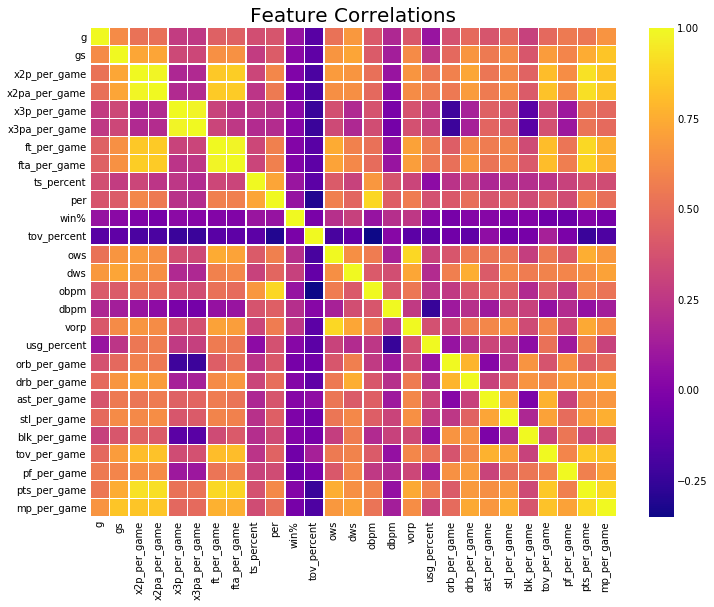

In [60]:
# Correlation plot of features
corr = nba_df[features].corr()

plt.figure(figsize=(10.5,9))

sns.heatmap(corr, cmap='plasma', linewidths=0.3)
plt.title('Feature Correlations', fontsize=20)

plt.savefig('COR_allNBA.png', dpi=300)

In [61]:
nba_df.describe()

,seas_id,season,player_id,birth_year,age,experience,g,mp,per,ts_percent,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,win%
count,15775.000000,15775.00000,15775.000000,240.000000,15775.000000,15775.000000,15775.000000,15775.000000,15772.000000,15720.000000,...,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000
mean,20550.693122,2006.13141,3322.802345,1972.179167,26.703708,5.461236,52.634295,1238.907195,12.774987,0.512754,...,1.001065,2.577965,3.577623,1.868095,0.661160,0.416983,1.211949,1.881236,8.303803,0.494632
std,5620.749417,10.07241,764.817857,11.524995,4.193926,3.999985,25.252837,911.732228,6.245016,0.093283,...,0.851487,1.811490,2.532586,1.858277,0.465952,0.493886,0.810218,0.836590,6.046687,0.156170
min,10939.000000,1988.00000,1204.000000,1949.000000,18.000000,1.000000,1.000000,0.000000,-90.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106061
25%,15704.500000,1998.00000,2706.000000,1962.000000,23.000000,2.000000,33.000000,389.000000,9.900000,0.481000,...,0.400000,1.300000,1.700000,0.600000,0.300000,0.100000,0.600000,1.300000,3.600000,0.365854
50%,20450.000000,2006.00000,3307.000000,1972.000000,26.000000,4.000000,59.000000,1146.000000,12.900000,0.523000,...,0.700000,2.200000,3.000000,1.300000,0.600000,0.300000,1.000000,1.900000,6.800000,0.512195
75%,25428.500000,2015.00000,3903.000000,1983.000000,30.000000,8.000000,75.000000,1971.000000,15.900000,0.559000,...,1.400000,3.400000,4.800000,2.500000,0.900000,0.500000,1.700000,2.500000,11.800000,0.609756
max,30459.000000,2022.00000,5024.000000,1999.000000,44.000000,22.000000,85.000000,3533.000000,133.800000,1.500000,...,6.800000,12.300000,18.700000,14.500000,3.200000,4.600000,5.700000,6.000000,36.100000,0.890244


### Import Machine Learning Libraries

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Split dataset into Training and Testing sets

In [63]:
# Apply mask to reduce the number of data points based on the stats distribution of winners and losers
mask = (nba_df.season_name != '2021-22') & (nba_df.ws > 3.0) & (nba_df.mp > 1200)
df = nba_df[mask]


In [64]:
# Features
X = df[features].values

#Target variables
y = df['all_nba_team']
y_dummy = pd.get_dummies(y).values # One hot encode target variable

# Split data into a training and testing set with 70/30 split.
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, test_size=0.30)

# Scale the Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build DNN Model Function

In [65]:
def model_build(activation, loss, dropout):
    
    # Create model
    model = Sequential()
    
    #Input layer
    model.add(Dense(28,input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout))
    
    #Hidden layers
    model.add(Dense(14,  activation=activation))
    model.add(Dropout(dropout))
    
    model.add(Dense(8,  activation=activation))
    model.add(Dropout(dropout))
    
    #Output layer with softma activation
    model.add(Dense(4, activation='softmax'))
    
    # Compile model
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    
    return model

### Define early stop parameter

In [66]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', mode ='min',
                           verbose=0, patience=25)

### Build CV Search Grid

In [67]:
estimator = KerasClassifier(build_fn=model_build, epochs=250, batch_size=25, verbose=0)

# Define the grid search parameters
activation = ['relu', 'sigmoid']
loss_func = ['categorical_crossentropy', 'kullback_leibler_divergence']
dropout = [0, 0.2]
param_grid = dict(activation=activation, loss=loss_func, dropout=dropout)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test),  
                       callbacks=[early_stop], workers=0)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.923186 using {'activation': 'sigmoid', 'dropout': 0, 'loss': 'kullback_leibler_divergence'}
0.921192 (0.007958) with: {'activation': 'relu', 'dropout': 0, 'loss': 'categorical_crossentropy'}
0.921762 (0.007790) with: {'activation': 'relu', 'dropout': 0, 'loss': 'kullback_leibler_divergence'}
0.922047 (0.004226) with: {'activation': 'relu', 'dropout': 0.2, 'loss': 'categorical_crossentropy'}
0.922901 (0.002841) with: {'activation': 'relu', 'dropout': 0.2, 'loss': 'kullback_leibler_divergence'}
0.923186 (0.003056) with: {'activation': 'sigmoid', 'dropout': 0, 'loss': 'categorical_crossentropy'}
0.923186 (0.003199) with: {'activation': 'sigmoid', 'dropout': 0, 'loss': 'kullback_leibler_divergence'}
0.920625 (0.003697) with: {'activation': 'sigmoid', 'dropout': 0.2, 'loss': 'categorical_crossentropy'}
0.919203 (0.002261) with: {'activation': 'sigmoid', 'dropout': 0.2, 'loss': 'kullback_leibler_divergence'}


### Train best model to get history

In [68]:
best_par = grid_result.best_params_

best_estimator = model_build(activation=best_par['activation'], 
                             loss=best_par['loss'], dropout=best_par['dropout'])

history = best_estimator.fit(X_train, y_train,
                             validation_data=(X_test,y_test), 
                             callbacks=[early_stop], epochs=600,  verbose=0)

### Loss Function and Accuracy

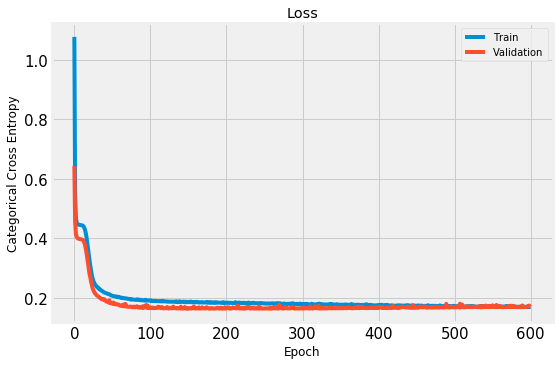

In [69]:
plt.figure(figsize=(8,5.5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.ylim(0.02, 0.25)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.title('Loss', )
plt.savefig('CatCrossEtropyLoss.png', dpi=200, bbox_inches='tight')

Text(0, 0.5, 'Categorical Accuracy')

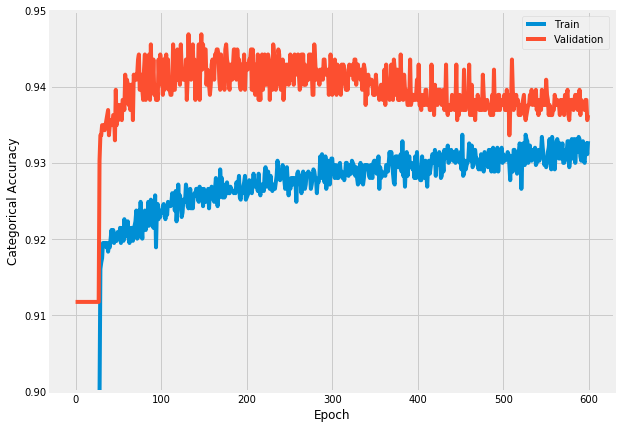

In [70]:
plt.figure(figsize=(9,7))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.ylim(.90,.95)
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')

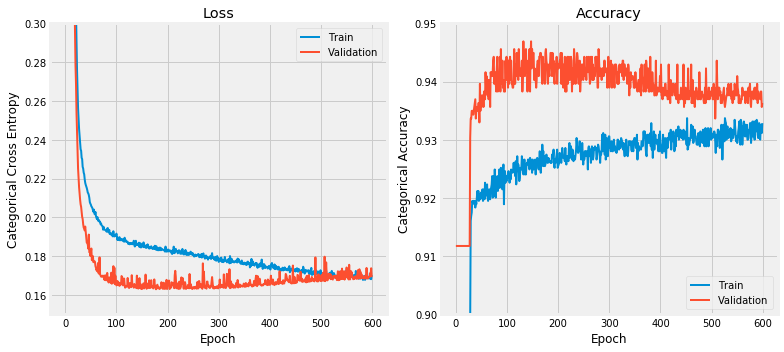

In [71]:
fig, ax = plt.subplots(ncols = 2, figsize = (11, 5))

ax[0].set(xlabel ='Epoch', ylabel = 'Categorical Cross Entropy',
          ylim = (0.15, 0.30), title='Loss')
ax[0].plot(history.history['loss'], label='Train', lw=2)
ax[0].plot(history.history['val_loss'], label='Validation', lw = 2)
ax[0].legend()

ax[1].set(xlabel = 'Epoch', ylabel = 'Categorical Accuracy', 
          ylim = (0.90, 0.95), title='Accuracy' )
ax[1].plot(history.history['accuracy'], label='Train', lw = 2)
ax[1].plot(history.history['val_accuracy'], label='Validation', lw = 2)
ax[1].legend()

fig.tight_layout()
fig.savefig('LossFunc.png', dpi = 300)

### DNN Model Shape

In [72]:
best_estimator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 28)                784       
_________________________________________________________________
dropout_9 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 14)                406       
_________________________________________________________________
dropout_10 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 120       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

### Use model to predict All-NBA Teams for the 2021-22 Season

In [73]:
mask = (nba_df.season_name == '2021-22') & (nba_df.ws > 3.0) & (nba_df.mp > 1200)
df_2022 = nba_df[mask][features]
df_2022 = df_2022.values
X_2022 = scaler.transform(df_2022)
prediction = best_estimator.predict_proba(X_2022)

In [74]:
pred_df = pd.DataFrame(prediction, columns = ['1st', '2nd', '3rd', 'NA'])

In [75]:
pred_df.head()

,1st,2nd,3rd,NA
0,2.172500e-06,0.000007,0.000033,0.999958
1,8.662947e-07,0.000002,0.000010,0.999987
2,1.194360e-06,0.000003,0.000015,0.999981
3,9.092582e-01,0.077996,0.010166,0.002580
4,1.274853e-06,0.000003,0.000016,0.999979


In [76]:
# Merge with original database
pred_df = pd.merge(nba_df[mask] ,pred_df, on=pred_df.index) 

In [77]:
pred_df.head()

,key_0,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,...,season_name,all_nba_team,sp_id,mx_tm,tm_y,win%,1st,2nd,3rd,NA
0,0,29648,2022,4219,Aaron Gordon,NaN,PF,26.0,8,NBA,...,2021-22,no,2021-224219,DEN,DEN,0.585366,2.172500e-06,0.000007,0.000033,0.999958
1,1,30017,2022,3761,Jeff Green,NaN,C,35.0,14,NBA,...,2021-22,no,2021-223761,DEN,DEN,0.585366,8.662947e-07,0.000002,0.000010,0.999987
2,2,30215,2022,4551,Monte Morris,NaN,PG,26.0,5,NBA,...,2021-22,no,2021-224551,DEN,DEN,0.585366,1.194360e-06,0.000003,0.000015,0.999981
3,3,30249,2022,4352,Nikola Jokić,NaN,C,26.0,7,NBA,...,2021-22,no,2021-224352,DEN,DEN,0.585366,9.092582e-01,0.077996,0.010166,0.002580
4,4,30442,2022,4140,Will Barton,NaN,SG,31.0,10,NBA,...,2021-22,no,2021-224140,DEN,DEN,0.585366,1.274853e-06,0.000003,0.000016,0.999979


### Tabulate votes based on weights (5pts for 1st Team, 3pts for 2nd Team and 1pts for 3rd Team)

In [78]:
pred_df['tabulate'] = pred_df['1st']*5.0 + pred_df['2nd']*3.0 + pred_df['3rd']*1.0

vote_tab_df = pred_df[['player', 'pos','1st', '2nd', '3rd','tabulate']].sort_values(by='tabulate', 
                                                                ignore_index=True, ascending=False)

## Top 25 Player voting

In [79]:
vote_tab_df.head(25)

,player,pos,1st,2nd,3rd,tabulate
0,Nikola Jokić,C,0.909258,0.077996,0.010166,4.790443
1,Luka Dončić,PG,0.846746,0.126755,0.020392,4.634387
2,Giannis Antetokounmpo,PF,0.807547,0.157551,0.027370,4.537756
3,Joel Embiid,C,0.736086,0.209422,0.042063,4.350760
4,Ja Morant,PG,0.497426,0.350365,0.107683,3.645910
5,Trae Young,PG,0.273342,0.428298,0.198173,2.849774
6,Kevin Durant,PF,0.274628,0.424895,0.199792,2.847617
7,Jayson Tatum,SF,0.226286,0.425021,0.225324,2.631815
8,LeBron James,SF,0.191077,0.385856,0.245789,2.358744
9,Chris Paul,PG,0.214038,0.319028,0.182259,2.209533


In [80]:
vote_tab_df.to_csv(r'All-NBA Votes.csv', index=False)

## ALL-NBA Team Selection by Position

<table style="width: 900px;">
<tbody>
<tr>
<td style="width: 65px; text-align: center;" rowspan="2">
<p><strong>Position</strong></p>
</td>
<td style="width: 182px; text-align: center;" colspan="2">
<p><strong>All-NBA First Team</strong></p>
</td>
<td style="width: 186px; text-align: center;" colspan="2">
<p><strong>ALL-NBA Second Team</strong></p>
</td>
<td style="width: 187px; text-align: center;" colspan="2">
<p><strong>All-NBA Third Team</strong></p>
</td>
</tr>
<tr>
<td style="width: 125px;">
<p><strong>Player</strong></p>
</td>
<td style="width: 57px; text-align: center;">
<p><strong>Score</strong></p>
</td>
<td style="width: 122px;">
<p><strong>Player</strong></p>
</td>
<td style="width: 64px; text-align: center;">
<p><strong>Score</strong></p>
</td>
<td style="width: 115px;">
<p><strong>Player</strong></p>
</td>
<td style="width: 72px; text-align: center;">
<p><strong>Score</strong></p>
</td>
</tr>
<tr>
<td style="width: 87px; text-align: center;">
<p>F</p>
</td>
<td style="width: 125px;">
<p>Giannis Antetokounmpo</p>
</td>
<td style="width: 57px; text-align: center;">
<p>4.53</p>
</td>
<td style="width: 122px;">
<p>Kevin Durant</p>
</td>
<td style="width: 64px; text-align: center;">
<p>2.84</p>
</td>
<td style="width: 115px;">
<p>Khris Middleton</p>
</td>
<td style="width: 72px; text-align: center;">
<p>0.25</p>
</td>
</tr>
<tr>
<td style="width: 87px; text-align: center;">
<p>F</p>
</td>
<td style="width: 125px;">
<p>Anthony Davis</p>
</td>
<td style="width: 57px; text-align: center;">
<p>2.64</p>
</td>
<td style="width: 122px;">
<p>Jimmy Butler</p>
</td>
<td style="width: 64px; text-align: center;">
<p>0.75</p>
</td>
<td style="width: 115px;">
<p>Jayson Tatum</p>
</td>
<td style="width: 72px; text-align: center;">
<p>0.19</p>
</td>
</tr>
<tr>
<td style="width: 87px; text-align: center;">
<p>C</p>
</td>
<td style="width: 125px;">
<p>Nikola Jokić</p>
</td>
<td style="width: 57px; text-align: center;">
<p>1.20</p>
</td>
<td style="width: 122px;">
<p>Rudy Gobert</p>
</td>
<td style="width: 64px; text-align: center;">
<p>0.82</p>
</td>
<td style="width: 115px;">
<p>Joel Embiid</p>
</td>
<td style="width: 72px; text-align: center;">
<p>0.60</p>
</td>
</tr>
<tr>
<td style="width: 87px; text-align: center;">
<p>G</p>
</td>
<td style="width: 125px;">
<p>LeBron James</p>
</td>
<td style="width: 57px; text-align: center;">
<p>4.46</p>
</td>
<td style="width: 122px;">
<p>Luka Dončić</p>
</td>
<td style="width: 64px; text-align: center;">
<p>3.72</p>
</td>
<td style="width: 115px;">
<p>Trae Young</p>
</td>
<td style="width: 72px; text-align: center;">
<p>2.38</p>
</td>
</tr>
<tr>
<td style="width: 87px; text-align: center;">
<p>G</p>
</td>
<td style="width: 125px;">
<p>James Harden</p>
</td>
<td style="width: 57px; text-align: center;">
<p>4.07</p>
</td>
<td style="width: 122px;">
<p>Damian Lillard</p>
</td>
<td style="width: 64px; text-align: center;">
<p>2.88</p>
</td>
<td style="width: 115px;">
<p>Russell Westbrook</p>
</td>
<td style="width: 72px; text-align: center;">
<p>0.86</p>
</td>
</tr>
</tbody>
</table>

In [81]:
print(datetime.now() - sartTime)

9:25:01.112519
